In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [31]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.quickplots import draw_projection_plots

### Collect data

In [32]:
DATASET_ID = 'canary_segmented'

In [33]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [34]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'canary.pickle'
df_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/syllable_dfs/canary_segmented/canary.pickle')

In [35]:
syllable_df = pd.read_pickle(df_loc)

In [36]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,rate,spectrogram,phrase,med_time
0,0.000,0.036,bird3,0,bird3_0525_2004_04_19_16_06,48000,"[[0, 0, 0, 0, 0, 0, 206, 254, 90, 0, 18, 0, 0,...",2,0.0180
1,0.101,0.136,bird3,0,bird3_0525_2004_04_19_16_06,48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,0.1185
2,0.208,0.247,bird3,0,bird3_0525_2004_04_19_16_06,48000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,0.2275


In [37]:
len(syllable_df)

482608

In [38]:
import tensorflow as tf

In [39]:
ensure_dir(DATA_DIR / 'tfrecords')

In [40]:
for idx, row in tqdm(syllable_df.iterrows(), total=len(syllable_df)):
    break

In [41]:
row

start_time                                                     0
end_time                                                   0.036
indv                                                       bird3
indvi                                                          0
key                                  bird3_0525_2004_04_19_16_06
rate                                                       48000
spectrogram    [[0, 0, 0, 0, 0, 0, 206, 254, 90, 0, 18, 0, 0,...
phrase                                                         2
med_time                                                   0.018
Name: 0, dtype: object

In [47]:
np.shape(row.spectrogram)

(32, 24)

In [2]:
import avgn.tensorflow.data as tfdata

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [81]:
record_loc = DATA_DIR / 'tfrecords' / "canary_32x24.tfrecord"
record_loc

PosixPath('/local/home/tsainbur/github_repos/avgn_paper/data/tfrecords/canary_32x24.tfrecord')

In [97]:
with tf.io.TFRecordWriter((record_loc).as_posix()) as writer:
    for idx, row in tqdm(syllable_df.iterrows(), total=len(syllable_df)):
        example = tfdata.serialize_example(
            {
                "spectrogram": {
                    "data": row.spectrogram.flatten().tobytes(),
                    "_type": tfdata._bytes_feature,
                },
                "index": {
                    "data": idx,
                    "_type": tfdata._int64_feature,
                },
                "indv": {
                    "data": np.string_(row.indv).astype("|S7"),
                    "_type": tfdata._bytes_feature,
                },
                "phrase": {
                    "data":  int(row.phrase),
                    "_type": tfdata._int64_feature,
                },
            }
        )
        # write the defined example into the dataset
        writer.write(example)

### test read data back

In [98]:
from tensorflow.io import FixedLenFeature, parse_single_example

In [99]:
# read the dataset
raw_dataset = tf.data.TFRecordDataset([record_loc.as_posix()])

In [100]:
data_types = {
    "spectrogram": tf.uint8,
    "index": tf.int64,
    "phrase": tf.int64,
    "indv": tf.string,
}

In [101]:
# parse each data type to the raw dataset
dataset = raw_dataset.map(lambda x: tfdata._parse_function(x, data_types=data_types))

In [102]:
# shuffle the dataset
dataset = dataset.shuffle(buffer_size=10000)
# create batches
dataset = dataset.batch(10)

In [103]:
spec, index, phrase, indv  = next(iter(dataset))

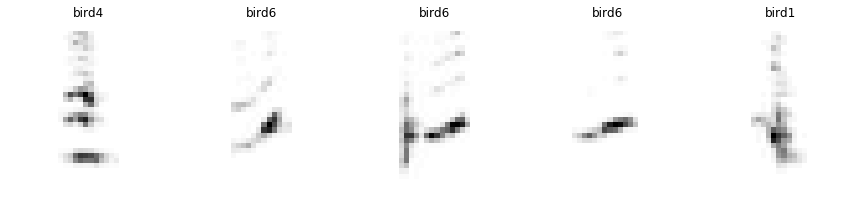

In [104]:
fig, ax = plt.subplots(ncols = 5, figsize=(15,3))
for i in range(5):
    # show the image
    ax[i].matshow(spec[i].numpy().reshape(32,24), cmap=plt.cm.Greys, origin="lower")
    string_label = indv[i].numpy().decode("utf-8") 
    ax[i].set_title(string_label)
    ax[i].axis('off')